Loading and exploring data...
Dataset shape: (284807, 31)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     28480

  File "C:\Users\rawat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rawat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rawat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rawat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Original class distribution: [170588    295]
Resampled class distribution: [34116 17058]

Training and evaluating models...

1. Training Logistic Regression...
Accuracy: 0.9799
Precision: 0.0700
Recall: 0.8586
F1 Score: 0.1295
AUC-ROC: 0.9677
Average Precision: 0.6784
Confusion Matrix:
[[55734  1129]
 [   14    85]]

2. Training Random Forest...
Accuracy: 0.9992
Precision: 0.7857
Recall: 0.7778
F1 Score: 0.7817
AUC-ROC: 0.9759
Average Precision: 0.7758
Confusion Matrix:
[[56842    21]
 [   22    77]]

3. Training XGBoost...
Accuracy: 0.9971
Precision: 0.3596
Recall: 0.8283
F1 Score: 0.5015
AUC-ROC: 0.9712
Average Precision: 0.7521
Confusion Matrix:
[[56717   146]
 [   17    82]]

4. Training LightGBM...
[LightGBM] [Info] Number of positive: 17058, number of negative: 34116
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Nu

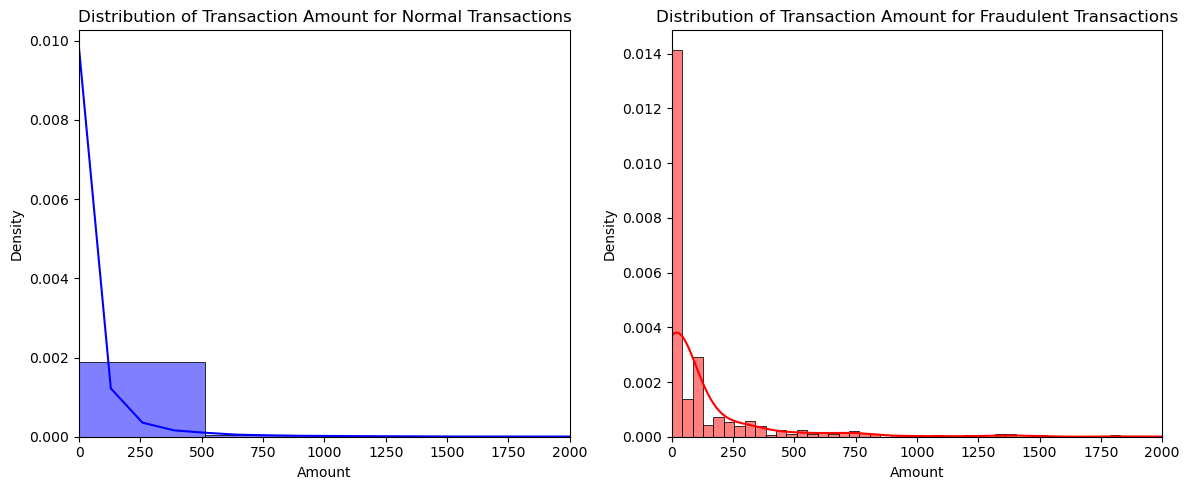

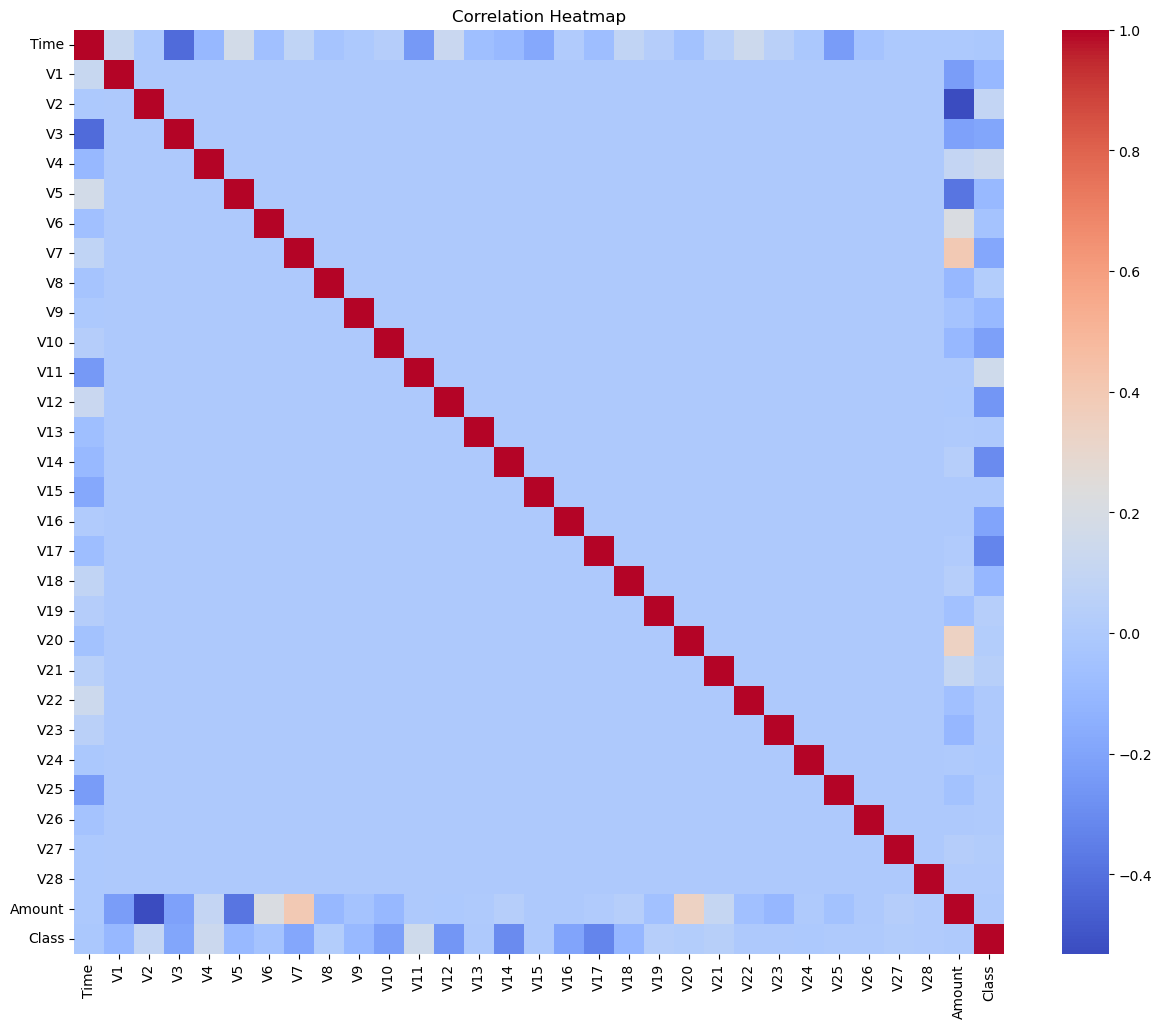

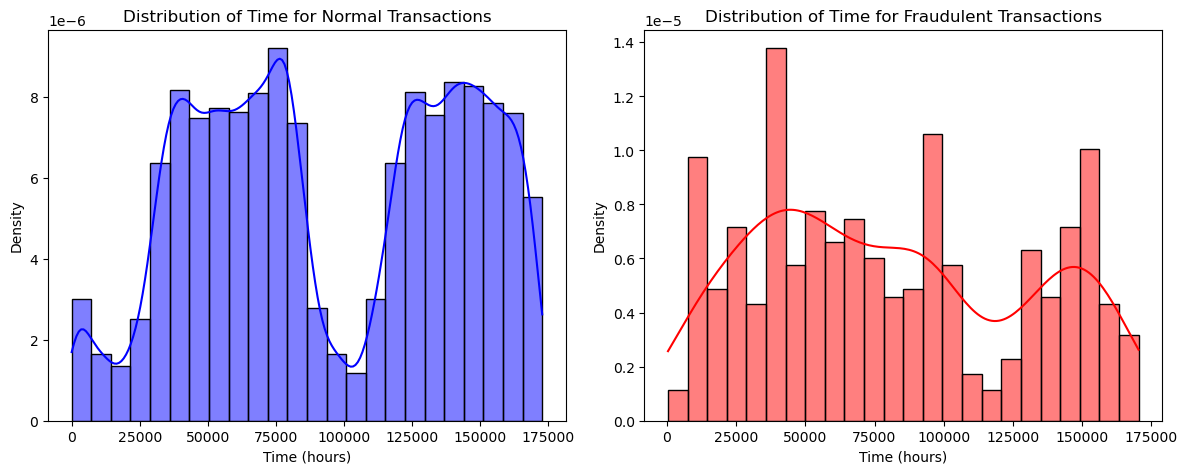

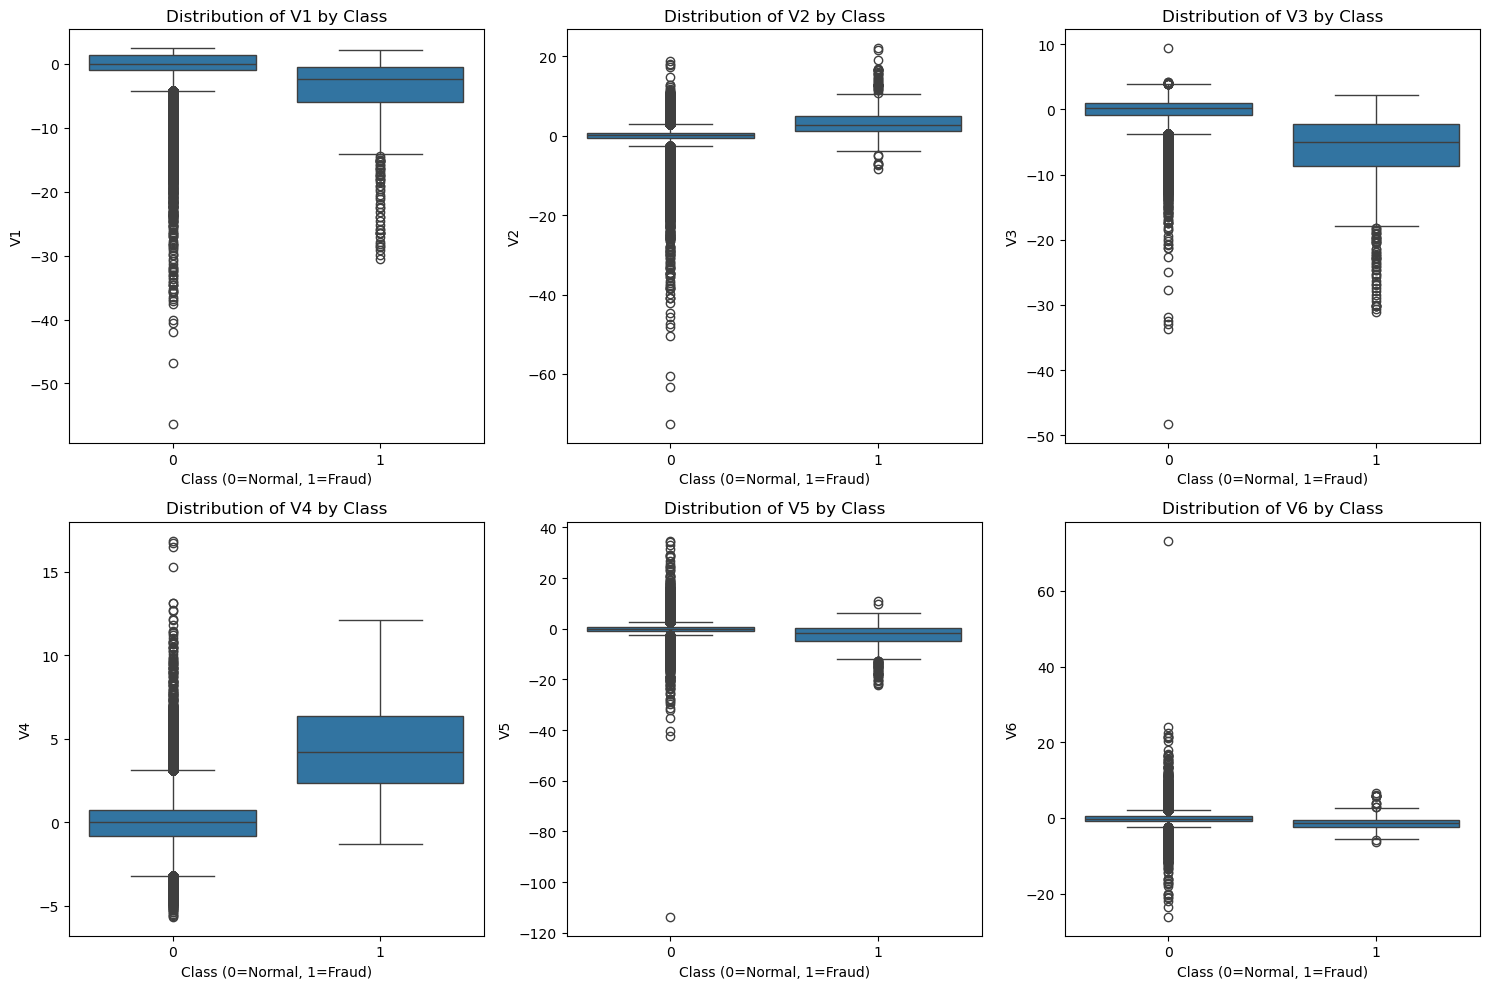

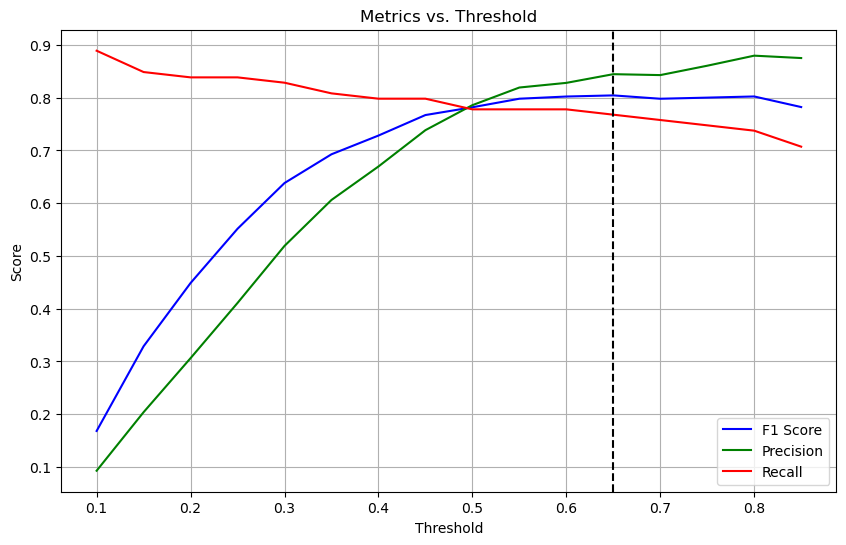

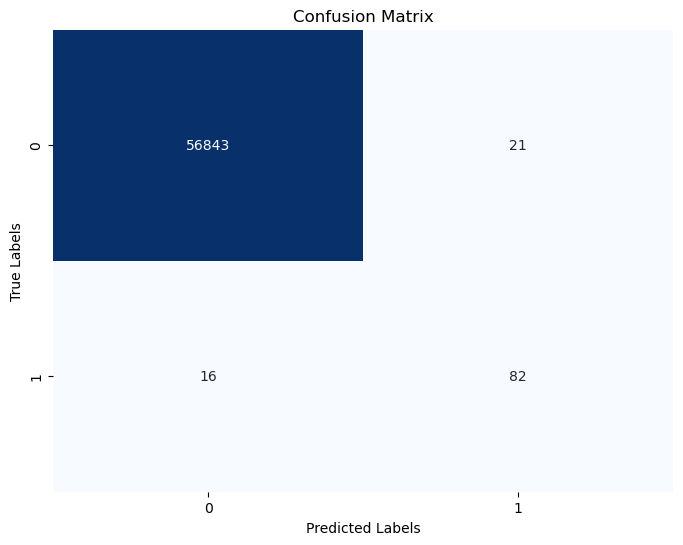

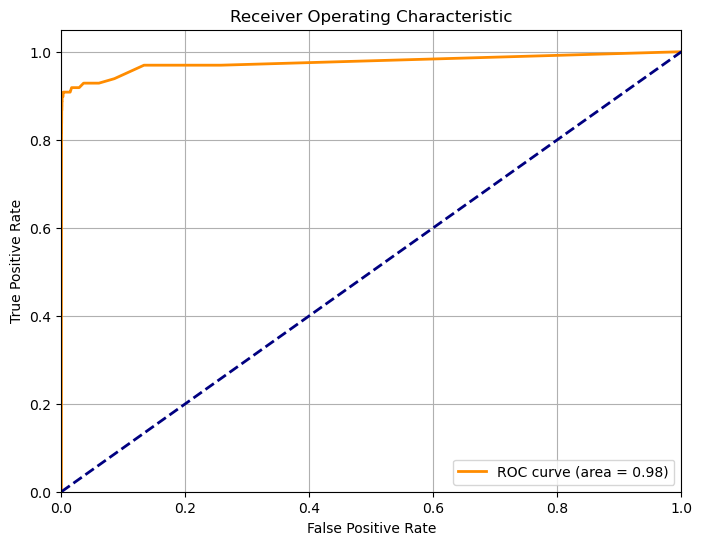

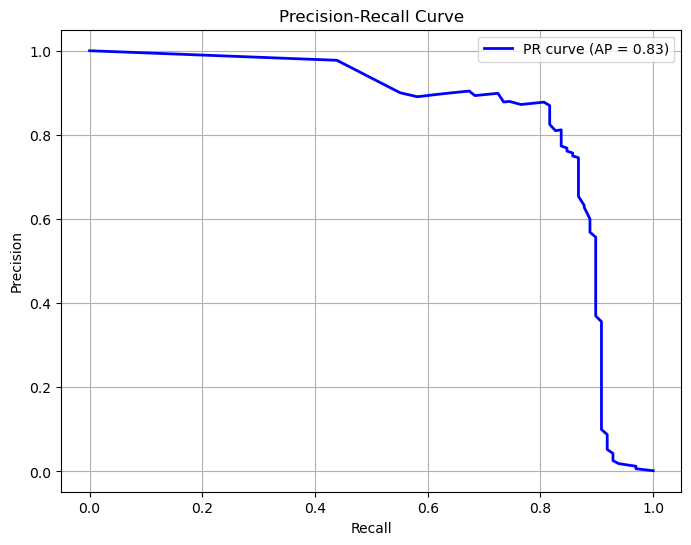

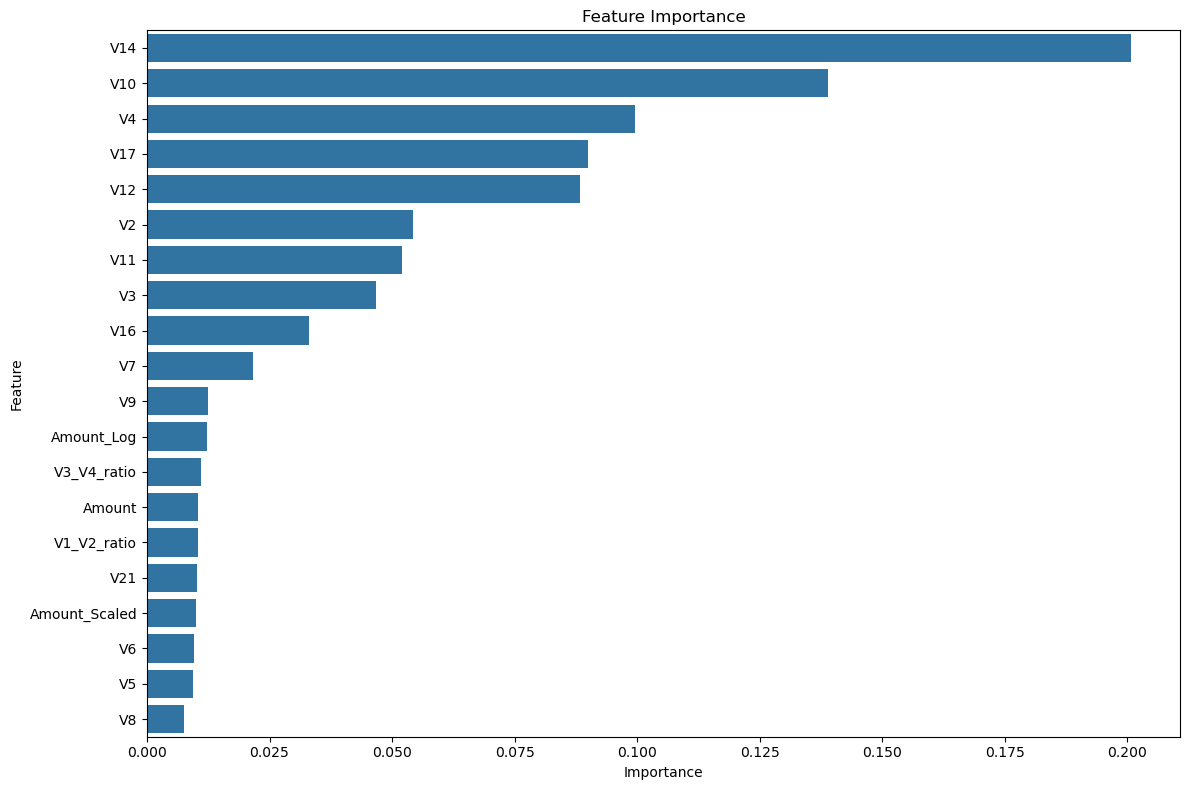

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import warnings
import time
warnings.filterwarnings('ignore')

# Data Loading and Exploration
def load_and_explore_data(file_path):
    """
    Load and explore the credit card fraud dataset
    """
    print("Loading and exploring data...")
    # Load the dataset
    df = pd.read_csv('Downloads/creditcard.csv')
    
    # Basic information
    print(f"Dataset shape: {df.shape}")
    print("\nDataset info:")
    print(df.info())
    
    # Check for missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Class distribution
    print("\nClass distribution:")
    print(df['Class'].value_counts())
    print(f"Fraud percentage: {df['Class'].mean() * 100:.4f}%")
    
    # Statistical summary
    print("\nStatistical summary:")
    print(df.describe())
    
    return df

# Data Preprocessing
def preprocess_data(df):
    """
    Preprocess the data for model training
    """
    print("\nPreprocessing data...")
    
    # Time feature engineering
    df['Time_Hour'] = df['Time'] / 3600  # Convert to hours
    df['Time_Hour'] = df['Time_Hour'] % 24  # Hour of day
    
    # Amount feature engineering
    df['Amount_Scaled'] = StandardScaler().fit_transform(df[['Amount']])
    df['Amount_Log'] = np.log(df['Amount'] + 1)
    
    # Create additional features
    df['V1_V2_ratio'] = df['V1'] / (df['V2'] + 1e-8)
    df['V3_V4_ratio'] = df['V3'] / (df['V4'] + 1e-8)
    
    # Drop original Time column
    X = df.drop(['Class', 'Time'], axis=1)
    y = df['Class']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Exploratory Data Analysis
def perform_eda(df):
    """
    Perform exploratory data analysis on the dataset
    """
    print("\nPerforming exploratory data analysis...")
    
    # Distribution of transaction amount by class
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, kde=True, color='blue', stat='density')
    plt.title('Distribution of Transaction Amount for Normal Transactions')
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.xlim(0, 2000)
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, kde=True, color='red', stat='density')
    plt.title('Distribution of Transaction Amount for Fraudulent Transactions')
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.xlim(0, 2000)
    
    plt.tight_layout()
    plt.savefig('amount_distribution.png')
    
    # Correlation heatmap
    plt.figure(figsize=(15, 12))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.savefig('correlation_heatmap.png')
    
    # Distribution of Time by class
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[df['Class'] == 0]['Time'], bins=24, kde=True, color='blue', stat='density')
    plt.title('Distribution of Time for Normal Transactions')
    plt.xlabel('Time (hours)')
    plt.ylabel('Density')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df[df['Class'] == 1]['Time'], bins=24, kde=True, color='red', stat='density')
    plt.title('Distribution of Time for Fraudulent Transactions')
    plt.xlabel('Time (hours)')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.savefig('time_distribution.png')
    
    # PCA feature analysis
    plt.figure(figsize=(15, 10))
    
    for i, feature in enumerate(['V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 1):
        plt.subplot(2, 3, i)
        sns.boxplot(x='Class', y=feature, data=df)
        plt.title(f'Distribution of {feature} by Class')
        plt.xlabel('Class (0=Normal, 1=Fraud)')
        plt.ylabel(feature)
    
    plt.tight_layout()
    plt.savefig('feature_boxplots.png')
    
    print("EDA completed. Visualizations saved.")

# Handle Class Imbalance
def handle_imbalance(X_train, y_train, strategy='combined'):
    """
    Handle class imbalance using various resampling techniques
    """
    print(f"\nHandling class imbalance using {strategy} strategy...")
    
    if strategy == 'smote':
        # Apply SMOTE oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        
    elif strategy == 'undersampling':
        # Apply random undersampling
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        
    elif strategy == 'combined':
        # Combined approach: undersampling majority + SMOTE minority
        over = SMOTE(sampling_strategy=0.1, random_state=42)
        under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        steps = [('over', over), ('under', under)]
        pipeline = Pipeline(steps=steps)
        X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
    
    else:
        # No resampling
        X_resampled, y_resampled = X_train, y_train
    
    print(f"Original class distribution: {np.bincount(y_train)}")
    print(f"Resampled class distribution: {np.bincount(y_resampled)}")
    
    return X_resampled, y_resampled

# Model Training and Evaluation
def train_and_evaluate_models(X_train, X_val, y_train, y_val):
    """
    Train and evaluate multiple models for credit card fraud detection
    """
    print("\nTraining and evaluating models...")
    
    # Dictionary to store model results
    model_results = {}
    
    # 1. Logistic Regression (baseline)
    print("\n1. Training Logistic Regression...")
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    lr_val_pred = lr.predict_proba(X_val)[:, 1]
    model_results['Logistic Regression'] = evaluate_model(lr, X_val, y_val, lr_val_pred)
    
    # 2. Random Forest
    print("\n2. Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_val_pred = rf.predict_proba(X_val)[:, 1]
    model_results['Random Forest'] = evaluate_model(rf, X_val, y_val, rf_val_pred)
    
    # 3. XGBoost
    print("\n3. Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        random_state=42,
        tree_method='hist'
    )
    xgb_model.fit(X_train, y_train)
    xgb_val_pred = xgb_model.predict_proba(X_val)[:, 1]
    model_results['XGBoost'] = evaluate_model(xgb_model, X_val, y_val, xgb_val_pred)
    
    # 4. LightGBM
    print("\n4. Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    lgb_model.fit(X_train, y_train)
    lgb_val_pred = lgb_model.predict_proba(X_val)[:, 1]
    model_results['LightGBM'] = evaluate_model(lgb_model, X_val, y_val, lgb_val_pred)
    
    # Find the best model
    best_model_name = max(model_results, key=lambda x: model_results[x]['f1_score'])
    print(f"\nBest model: {best_model_name}")
    print(f"F1 Score: {model_results[best_model_name]['f1_score']:.4f}")
    print(f"AUC-ROC: {model_results[best_model_name]['auc_roc']:.4f}")
    print(f"Average Precision: {model_results[best_model_name]['avg_precision']:.4f}")
    
    # Return the best model and all results
    best_model = None
    if best_model_name == 'Logistic Regression':
        best_model = lr
    elif best_model_name == 'Random Forest':
        best_model = rf
    elif best_model_name == 'XGBoost':
        best_model = xgb_model
    elif best_model_name == 'LightGBM':
        best_model = lgb_model
    
    return best_model, model_results

def evaluate_model(model, X_val, y_val, y_pred_proba, threshold=0.5):
    """
    Evaluate model performance using various metrics
    """
    # Convert probability to binary prediction using threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Classification report
    report = classification_report(y_val, y_pred, output_dict=True)
    
    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Extract metrics
    accuracy = report['accuracy']
    precision_score = report['1']['precision']
    recall_score = report['1']['recall']
    f1_score = report['1']['f1-score']
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Return results dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc_roc': roc_auc,
        'avg_precision': avg_precision,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision,
        'recall_curve': recall
    }
    
    return results

def optimize_threshold(model, X_val, y_val):
    """
    Find the optimal threshold for binary classification
    """
    print("\nOptimizing classification threshold...")
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate metrics for different thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        report = classification_report(y_val, y_pred, output_dict=True)
        f1_scores.append(report['1']['f1-score'])
        precision_scores.append(report['1']['precision'])
        recall_scores.append(report['1']['recall'])
    
    # Find threshold with best F1 score
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    print(f"Optimal threshold: {best_threshold:.2f}")
    print(f"F1 Score at optimal threshold: {f1_scores[best_idx]:.4f}")
    print(f"Precision at optimal threshold: {precision_scores[best_idx]:.4f}")
    print(f"Recall at optimal threshold: {recall_scores[best_idx]:.4f}")
    
    # Plot threshold vs metrics
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
    plt.plot(thresholds, precision_scores, 'g-', label='Precision')
    plt.plot(thresholds, recall_scores, 'r-', label='Recall')
    plt.axvline(x=best_threshold, color='k', linestyle='--')
    plt.title('Metrics vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig('threshold_optimization.png')
    
    return best_threshold

def evaluate_final_model(model, X_test, y_test, threshold):
    """
    Evaluate the final model on the test set
    """
    print("\nEvaluating final model on test set...")
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig('confusion_matrix.png')
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.png')
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig('pr_curve.png')
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_test.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))
    
    return {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision
    }

# Main function
def main(file_path):
    """
    Main function to run the credit card fraud detection pipeline
    """
    start_time = time.time()
    
    # 1. Load and explore data
    df = load_and_explore_data(file_path)
    
    # 2. Perform EDA
    perform_eda(df)
    
    # 3. Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df)
    
    # 4. Handle class imbalance
    X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train, strategy='combined')
    
    # 5. Train and evaluate models
    best_model, model_results = train_and_evaluate_models(X_train_resampled, X_val, y_train_resampled, y_val)
    
    # 6. Optimize threshold
    best_threshold = optimize_threshold(best_model, X_val, y_val)
    
    # 7. Evaluate final model on test set
    final_results = evaluate_final_model(best_model, X_test, y_test, best_threshold)
    
    # 8. Print execution time
    end_time = time.time()
    print(f"\nExecution time: {end_time - start_time:.2f} seconds")
    
    return best_model, final_results

if __name__ == "__main__":
    # Path to the dataset
    file_path = "Downloads/creditcard.csv"  
    
    # Run the pipeline
    best_model, final_results = main(file_path)
    
    # Save the model
    import joblib
    joblib.dump(best_model, 'fraud_detection_model.pkl')
    print("\nModel saved as 'fraud_detection_model.pkl'")
    
    print("\nFraud Detection Model Training Complete!")